# Analytics - query to reference mapping

This notebook is based on and adapted from this scvi-tools tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/query_hlca_knn.html

In [22]:
import scvi
import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from pathlib import Path
import os
from scvi.hub import HubModel
import pynndescent
from PIL import ImageColor
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import scanpy as sc

scvi.settings.seed = 1

# plotting commands for the styling
# sns.reset_orig()
mplscience.set_style(reset_current=True, name="default")

%load_ext autoreload
%autoreload 2

Global seed set to 1


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Citations

scArches:  
Mohammad Lotfollahi, Mohsen Naghipourfar, Malte D. Luecken, Matin Khajavi, Maren Büttner, Marco Wagenstetter, Žiga Avsec, Adam Gayoso, Nir Yosef, Marta Interlandi, Sergei Rybakov, Alexander V. Misharin, and Fabian J. Theis. Mapping single-cell data to reference atlases by transfer learning. Nature Biotechnology, 40(1):121–130, August 2021. doi:10.1038/s41587-021-01001-7.  

scANVI:  
Chenling Xu, Romain Lopez, Edouard Mehlman, Jeffrey Regier, Michael I Jordan, and Nir Yosef. Probabilistic harmonization and annotation of single-cell transcriptomics data with deep generative models. Molecular Systems Biology, January 2021. doi:10.15252/msb.20209620.

HCLA:  
An integrated cell atlas of the human lung in health and disease
L Sikkema, D Strobl, L Zappia, E Madissoon, NS Markov, L Zaragosi, M Ansari, M Arguel, L Apperloo, C Bécavin, M Berg, E Chichelnitskiy, M Chung, A Collin, ACA Gay, B Hooshiar Kashani, M Jain, T Kapellos, TM Kole, C Mayr, M von Papen, L Peter, C Ramírez-Suástegui, J Schniering, C Taylor, T Walzthoeni, C Xu, LT Bui, C de Donno, L Dony, M Guo, AJ Gutierrez, L Heumos, N Huang, I Ibarra, N Jackson, P Kadur Lakshminarasimha Murthy, M Lotfollahi, T Tabib, C Talavera-Lopez, K Travaglini, A Wilbrey-Clark, KB Worlock, M Yoshida, Lung Biological Network Consortium, T Desai, O Eickelberg, C Falk, N Kaminski, M Krasnow, R Lafyatis, M Nikolíc, J Powell, J Rajagopal, O Rozenblatt-Rosen, MA Seibold, D Sheppard, D Shepherd, SA Teichmann, A Tsankov, J Whitsett, Y Xu, NE Banovich, P Barbry, TE Duong, KB Meyer, JA Kropski, D Pe’er, HB Schiller, PR Tata, JL Schultze, AV Misharin, MC Nawijn, MD Luecken, F Theis
bioRxiv 2022.03.10.483747; doi: https://doi.org/10.1101/2022.03.10.483747

## 1️⃣ Load the pre-trained model

Here we use the HLCA dataset.

An integrated cell atlas of the human lung in health and disease  
L Sikkema, D Strobl, L Zappia, E Madissoon, NS Markov, L Zaragosi, M Ansari, M Arguel, L Apperloo, C Bécavin, M Berg, E Chichelnitskiy, M Chung, A Collin, ACA Gay, B Hooshiar Kashani, M Jain, T Kapellos, TM Kole, C Mayr, M von Papen, L Peter, C Ramírez-Suástegui, J Schniering, C Taylor, T Walzthoeni, C Xu, LT Bui, C de Donno, L Dony, M Guo, AJ Gutierrez, L Heumos, N Huang, I Ibarra, N Jackson, P Kadur Lakshminarasimha Murthy, M Lotfollahi, T Tabib, C Talavera-Lopez, K Travaglini, A Wilbrey-Clark, KB Worlock, M Yoshida, Lung Biological Network Consortium, T Desai, O Eickelberg, C Falk, N Kaminski, M Krasnow, R Lafyatis, M Nikolíc, J Powell, J Rajagopal, O Rozenblatt-Rosen, MA Seibold, D Sheppard, D Shepherd, SA Teichmann, A Tsankov, J Whitsett, Y Xu, NE Banovich, P Barbry, TE Duong, KB Meyer, JA Kropski, D Pe’er, HB Schiller, PR Tata, JL Schultze, AV Misharin, MC Nawijn, MD Luecken, F Theis  
bioRxiv 2022.03.10.483747; doi: https://doi.org/10.1101/2022.03.10.483747

Let's download the pre-trained model

In [2]:
local_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref"

In [3]:
hm = HubModel.pull_from_huggingface_hub(repo_name="scvi-tools/human-lung-cell-atlas", cache_dir=local_dir, revision="main")

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/242 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/920M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

In [5]:
model = hm.model

INFO     Loading model...                                                                                          
INFO     File                                                                                                      
         /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref/models--scvi-tools--hum
         an-lung-cell-atlas/snapshots/cc220c54571ae585127f7469ccc7dbfa28eb0c30/model.pt already downloaded         


/Users/valehvpa/GitRepos/scvi-tools/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/Users/valehvpa/GitRepos/scvi-tools/scvi/data/fields/_scanvi.py:58: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [6]:
model

ScanVI Model with the following params: 
unlabeled_category: unlabeled, n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Trained
Model's adata is minified?: True

## 2️⃣ Learn a neighbors index on reference latent space + Download the query data

First let's get the latent space from our model and embeddings. It is essentially just the mean of the latent distribution.

In [9]:
ref = model.adata.obsm["SCANVI_latent_qzm"]
ref_nn_index = pynndescent.NNDescent(ref)
ref_nn_index.prepare()

For the query, we will use samples from the following publication:  

- Delorey, Toni M., et al. “COVID-19 tissue atlases reveal SARS-CoV-2 pathology and cellular targets.” Nature 595.7865 (2021): 107-113.

In [20]:
%%capture
%%bash
curl https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5230nnn/GSM5230027/suppl/GSM5230027_04-P103142-S149-R01_raw_feature_bc_matrix.h5.gz -o "query.h5.gz"
gzip -df query.h5.gz

In [23]:
geo_metadata_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171668/suppl/GSE171668_lung_metadata.csv.gz"
metadata = pd.read_csv(geo_metadata_url, index_col=0)
query_data = sc.read_10x_h5("query.h5")

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [24]:
query_data.var

,gene_ids,feature_types,genome
GRCh38___MIR1302-2HG,GRCh38___ENSG00000243485,Gene Expression,GRCh38
GRCh38___FAM138A,GRCh38___ENSG00000237613,Gene Expression,GRCh38
GRCh38___OR4F5,GRCh38___ENSG00000186092,Gene Expression,GRCh38
GRCh38___AL627309.1,GRCh38___ENSG00000238009,Gene Expression,GRCh38
GRCh38___AL627309.3,GRCh38___ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
SARSCoV2_SARSCoV2_ORF8,SARSCoV2_SARSCoV2_ORF8,Gene Expression,SARSCoV2
SARSCoV2_SARSCoV2_N,SARSCoV2_SARSCoV2_N,Gene Expression,SARSCoV2
SARSCoV2_SARSCoV2_ORF10,SARSCoV2_SARSCoV2_ORF10,Gene Expression,SARSCoV2
SARSCoV2_SARSCoV2_3prime,SARSCoV2_SARSCoV2_3prime,Gene Expression,SARSCoV2


In [25]:
# need gene ids as index to match the core HLCA data
query_data.var['gene_names'] = query_data.var.index
query_data.var.index = [idx.split("___")[-1] for idx in query_data.var.gene_ids]

In [26]:
# use metadata to select only cells of interest and remove empty drops
metadata = metadata.loc[metadata.donor == "D12_4",:].copy()
metadata.index = [idx.split("-")[-1] for idx in metadata.index]
# subset query_data to cells in metadata
query_data.obs.index = query_data.obs.index.str.rstrip("-1")
query_data = query_data[metadata.index, :].copy()

In [27]:
# add dataset information:
query_data.obs['dataset'] = "test_dataset_delorey_regev"

In [28]:
query_data

AnnData object with n_obs × n_vars = 1786 × 33567
    obs: 'dataset'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_names'

## 3️⃣ Build a query model

Use `prepare_query_anndata` to re-order the genes and pad any missing genes with 0s, so that query_adata matches exactly the reference in terms of its gene set.  

In [29]:
scvi.model.SCANVI.prepare_query_anndata(query_data, model)

INFO     Found 99.65% reference vars in query data.                                                                


/Users/valehvpa/GitRepos/scvi-tools/scvi/model/base/_archesmixin.py:225: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_padding = AnnData(


In [30]:
query_data.obs["scanvi_label"] = "unlabeled"

In [31]:
# scvi.model.SCANVI.view_setup_args(
#     "/Users/valehvpa/GitRepos/scvi-hub/local/data_stuff/HLCA/hlca_new/HLCA_reference_model_new_latent"
# )

In [34]:
query_model = scvi.model.SCANVI.load_query_data(query_data, model, accelerator = "cpu")

Train the query model.

In [35]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [42]:
query_model.train(
    max_epochs=surgery_epochs,
    use_gpu=False,
    accelerator="cpu",
    **train_kwargs_surgery,
)

INFO     Training for 500 epochs.                                                                                  


/Users/valehvpa/GitRepos/scvi-tools/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 184/500:  37%|███▋      | 184/500 [01:44<02:59,  1.76it/s, v_num=1, train_loss_step=507, train_loss_epoch=489]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 545.329. Signaling Trainer to stop.


In [44]:
query_save_path = f"{local_dir}/query_model"
query_model.save(query_save_path, overwrite=True)

In [45]:
query_emb = sc.AnnData(query_model.get_latent_representation())
query_emb.obs_names = query_data.obs_names

## 4️⃣ Predict

Now let’s try to predict an attribute in the query data using the reference (e.g. cell types or compartments) and save it in the query embedding object.   

We reuse the PyNNDescent index from before, converting distances to affinities, and weighting the predictions using these affinities. This follows the approach used in the HLCA.

In [46]:
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

In [47]:
def distances_to_affinities(distances):
    # convert distances to affinities
    stds = np.std(distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)
    distances_tilda = np.exp(-np.true_divide(distances, stds))
    weights = distances_tilda / np.sum(
        distances_tilda, axis=1, keepdims=True
    )
    return weights

# import numba
# @numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

weights = distances_to_affinities(ref_distances)

### 4️⃣.1️⃣ Figuring out what attribute to predict

Let's see what we can predict that we could then compare to the ground truth in the query data.

In [48]:
metadata.columns

Index(['donor', 'n_genes', 'n_counts', 'percent_mito', 'method', 'doublet',
       'predicted_celltype', 'compartment', 'manual_annotation_cluster',
       'manual_annotation_SubCluster', 'Viral+'],
      dtype='object')

In [49]:
metadata["compartment"].value_counts()

stromal        1079
endothelial     512
lymphoid         88
epithelial       76
myeloid          25
Name: compartment, dtype: int64

In [50]:
metadata["predicted_celltype"].value_counts()

myofibroblast            1031
vascular endothelial      415
lymphatic endothelial      97
AT1                        62
CD8+ T cell                57
pericyte                   28
club                       12
smc                        12
macrophage                 10
nkt                         8
fibroblast                  8
CD4+ T cell                 7
neutrophil                  7
plasma cell                 7
mast                        6
NK cell                     4
Treg                        3
B cell                      2
cDC                         2
AT2                         2
Name: predicted_celltype, dtype: int64

In [ ]:
# ann levels 2 or 3 seems to match the resolution in query_data, 1 is compartment level (e.g. Epithelial, Immune, etc.)
model.adata.obs[[
    "original_ann_level_1",
    "original_ann_level_2",
    "original_ann_level_3",
    "scanvi_label",
]]

,original_ann_level_1,original_ann_level_2,original_ann_level_3,scanvi_label
GCGACCATCCCTAACC_SC22,Immune,Myeloid,Macrophages,Macrophages
P2_1_GCGCAACCAGTTAACC,Immune,Lymphoid,Innate lymphoid cell NK,Non-T/B cells
GCTCTGTAGTGCTGCC_SC27,Epithelial,Alveolar epithelium,AT2,AT2
P2_8_TTAGGACGTTCAGGCC,Immune,Myeloid,Macrophages,Macrophages
CTTGATTGTCAGTTTG_T164,Epithelial,Airway epithelium,Basal,Basal
...,...,...,...,...
ACCTTTACATTAACCG_T120,Epithelial,Airway epithelium,Basal,Basal
CATTATCTCCATGAAC_F01639,Immune,Myeloid,Dendritic cells,Dendritic cells
AGGCCGTGTGTGACCC-SC56,Epithelial,Alveolar epithelium,AT2,AT2
CGATGGCAGCAGGCTA-1-2,Epithelial,Airway epithelium,Secretory,Secretory


### 4️⃣.2️⃣ Predict cell compartments

It looks like we can try to predict the compartment, and compare it to the ground truth compartment in the query data (which comes from the metadata object).  

In [ ]:
model.adata.obs.original_ann_level_1.value_counts()

Epithelial             281547
Immune                 226595
Endothelial             49738
Stroma                  25193
Proliferating cells      1811
Name: original_ann_level_1, dtype: int64

In [ ]:
metadata["compartment"].value_counts()

stromal        1079
endothelial     512
lymphoid         88
epithelial       76
myeloid          25
Name: compartment, dtype: int64

lymphoid and myeloid are essentially Immune.

In [ ]:
label_key = "original_ann_level_1"
ref_cats = model.adata.obs[label_key].cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(model.adata.obs[label_key].cat.categories)[p]
query_emb.obs["compartment_pred"], query_emb.obs["compartment_uncertainty"] = p, u

### 4️⃣.3️⃣ Evaluate predictions

Finally, let's evaluate predictions.

In [57]:
query_emb.obs[["compartment_pred", "compartment_uncertainty"]]

,compartment_pred,compartment_uncertainty
AAGCGTTTCAGTGCGC,Endothelial,0.000000e+00
AGCCACGAGGAGTCTG,Endothelial,5.960464e-08
ATCATTCGTATTTCGG,Endothelial,0.000000e+00
TGGCGTGCATGTAACC,Endothelial,0.000000e+00
CTACAGACACTGTGAT,Endothelial,0.000000e+00
...,...,...
TGATGCACATGGGCAA,Epithelial,1.192093e-07
AATGACCAGCCGATTT,Immune,5.960464e-08
CTCCATGCACTCTAGA,Stroma,0.000000e+00
ATGGGTTAGAGGCGTT,Epithelial,0.000000e+00


0.0027435729311401607 5.960464477539063e-08


<AxesSubplot: ylabel='Density'>

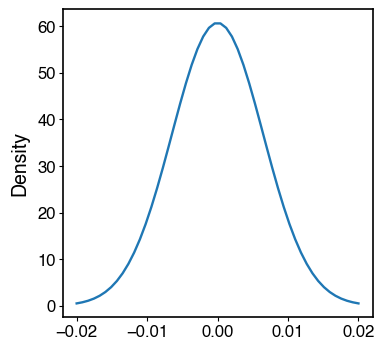

In [58]:
print(query_emb.obs["compartment_uncertainty"].mean(), np.quantile(query_emb.obs["compartment_uncertainty"], 0.75))
query_emb.obs["compartment_uncertainty"].plot(kind='density', ind=np.linspace(-0.02, 0.02))

In [59]:
def get_precision_recall(ground_truth: np.ndarray, pred: np.ndarray, do_round: bool = True):
    assert type(ground_truth) == np.ndarray and type(pred) == np.ndarray
    # https://stackoverflow.com/a/68157457
    tp = np.sum(np.logical_and(pred == 1, ground_truth == 1))
    fp = np.sum(np.logical_and(pred == 1, ground_truth == 0))
    fn = np.sum(np.logical_and(pred == 0, ground_truth == 1))
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    if precision == 0 and recall == 0:
        f1 = 0
    else:
        f1 = (2*precision*recall) / (precision+recall)
    if do_round:
        dec = 2
        return np.round(precision, dec), np.round(recall, dec), np.round(f1, dec)
    else:
        return precision, recall, f1

def binarize_array(arr, true_val: str) -> np.ndarray:
    v = [1 if val == true_val else 0 for val in arr]
    return np.array(v)

def evaluate_predictions(uncertainty_threshold = None):
    # build comparison_df
    assert metadata["compartment"].index.equals(query_emb.obs.index)
    comparison_df = pd.DataFrame(index=metadata["compartment"].index, columns=["pred", "ground_truth", "pred_uncertainty"])
    comparison_df["pred"] = query_emb.obs["compartment_pred"]
    comparison_df["pred_uncertainty"] = query_emb.obs["compartment_uncertainty"]
    comparison_df["ground_truth"] = metadata["compartment"].fillna(
                                                            "Unknown"
                                                        ).replace(
                                                            "stromal",
                                                            "stroma"
                                                        ).replace(
                                                            "lymphoid",
                                                            "immune"
                                                        ).replace(
                                                            "myeloid",
                                                            "immune"
                                                        ).str.capitalize()

    # we dont care about cases where we dont know the ground truth (in fact we could have skipped prediction for these altogether)
    n_before = len(comparison_df)
    comparison_df = comparison_df[comparison_df["ground_truth"] != "Unknown"]
    n_filtered = n_before-len(comparison_df)
    pct_filtered = 100*n_filtered/n_before
    print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with unknown ground truth")

    if uncertainty_threshold is not None:
        # filter out uncertainty > threshold
        n_before = len(comparison_df)
        comparison_df = comparison_df[comparison_df["pred_uncertainty"] <= uncertainty_threshold]
        n_filtered = n_before-len(comparison_df)
        pct_filtered = 100*n_filtered/n_before
        print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with pred uncertainty > {uncertainty_threshold}")

    # now calculate prediction accuracy
    match = comparison_df["pred"] == comparison_df["ground_truth"]
    accuracy = 100 * np.sum(match) / len(match)

    # compute F1 score for each predicted class
    unique_cats_pred = np.unique(comparison_df.pred)
    unique_cats_ground_truth = np.unique(comparison_df.ground_truth)
    # in our case this happens to be true but that's not always the case
    assert np.array_equal(unique_cats_pred, unique_cats_ground_truth)
    f1_scores = {}
    for cat in unique_cats_pred:
        binay_pred = binarize_array(comparison_df.pred, true_val=cat)
        binay_ground_truth = binarize_array(comparison_df.ground_truth, true_val=cat)
        f1_scores[cat] = get_precision_recall(binay_pred, binay_ground_truth)[2]

    return comparison_df, accuracy, f1_scores

In [60]:
comparison_df, accuracy, f1_scores = evaluate_predictions(uncertainty_threshold=0.2)
print(accuracy)
print(f1_scores)

filtered out 6 barcodes (0.34%) with unknown ground truth
filtered out 7 barcodes (0.39%) with pred uncertainty > 0.2
99.71799210377891
{'Endothelial': 1.0, 'Epithelial': 0.99, 'Immune': 0.99, 'Stroma': 1.0}


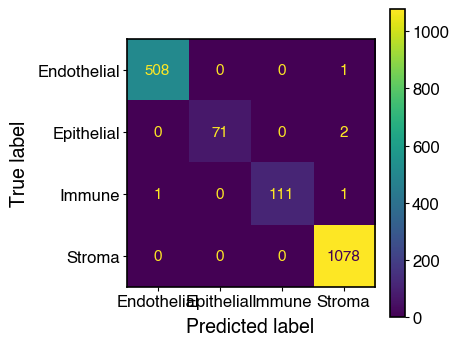

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(comparison_df["ground_truth"], comparison_df["pred"])

display_labels = list(f1_scores.keys())
cm_display = ConfusionMatrixDisplay(cm, display_labels=display_labels).plot()

In [79]:
temp_fig_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs"

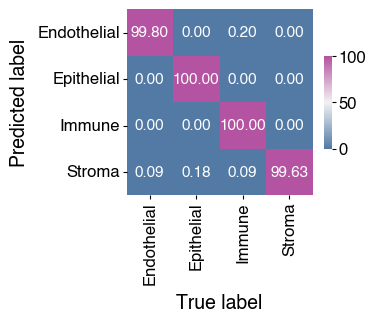

In [81]:
# https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cellassign_tutorial.html#Model-reproducibility
confusion_matrix = pd.crosstab(
    comparison_df["pred"],
    comparison_df["ground_truth"], 
    rownames=["Predicted label"],
    colnames=["True label"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
confusion_matrix *= 100
fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(
    confusion_matrix,
    cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    ax=ax,
    square=True,
    fmt=".2f",
    cbar_kws=dict(shrink=0.4, aspect=12),
    annot=True,
)

fig_path = f'{temp_fig_dir}/preds.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

## 5️⃣ Visualize embeddings in the joint latent space

Combine embeddings

In [132]:
query_emb.obs["dataset"] = "test_dataset_delorey_regev"
query_emb

AnnData object with n_obs × n_vars = 1786 × 30
    obs: 'celltype_pred', 'celltype_uncertainty', 'dataset'

In [133]:
reference_emb = sc.AnnData(model.adata.obsm["X_latent_qzm"])
reference_emb.obs_names = model.adata.obs_names
reference_emb.obs["dataset"] = model.adata.obs.dataset
reference_emb

AnnData object with n_obs × n_vars = 584884 × 30
    obs: 'dataset'

In [134]:
combined_emb = reference_emb.concatenate(query_emb)

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



In [135]:
combined_emb.obs["batch"].value_counts()

0    584884
1      1786
Name: batch, dtype: int64

In [136]:
combined_emb

AnnData object with n_obs × n_vars = 586670 × 30
    obs: 'dataset', 'celltype_pred', 'celltype_uncertainty', 'batch'

Visualize embeddings.

I do this on a device with more ram, but you can run it locally if you have enough ram.

In [ ]:
# sc.pp.neighbors(combined_emb, use_rep="X")
# sc.tl.umap(combined_emb, min_dist=0.3)

In [24]:
# combined_emb.write_h5ad(f"{local_dir}/combined_emb.h5ad")

# import scanpy as sc
# import anndata
# combined_emb = anndata.read_h5ad("combined_emb.h5ad")
# sc.pp.neighbors(combined_emb, use_rep="X")
# sc.tl.umap(combined_emb, min_dist=0.3)
# combined_emb.write_h5ad("combined_emb_umap.h5ad")

# combined_emb_umap = anndata.read_h5ad(f"{local_dir}/combined_emb_umap.h5ad")

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


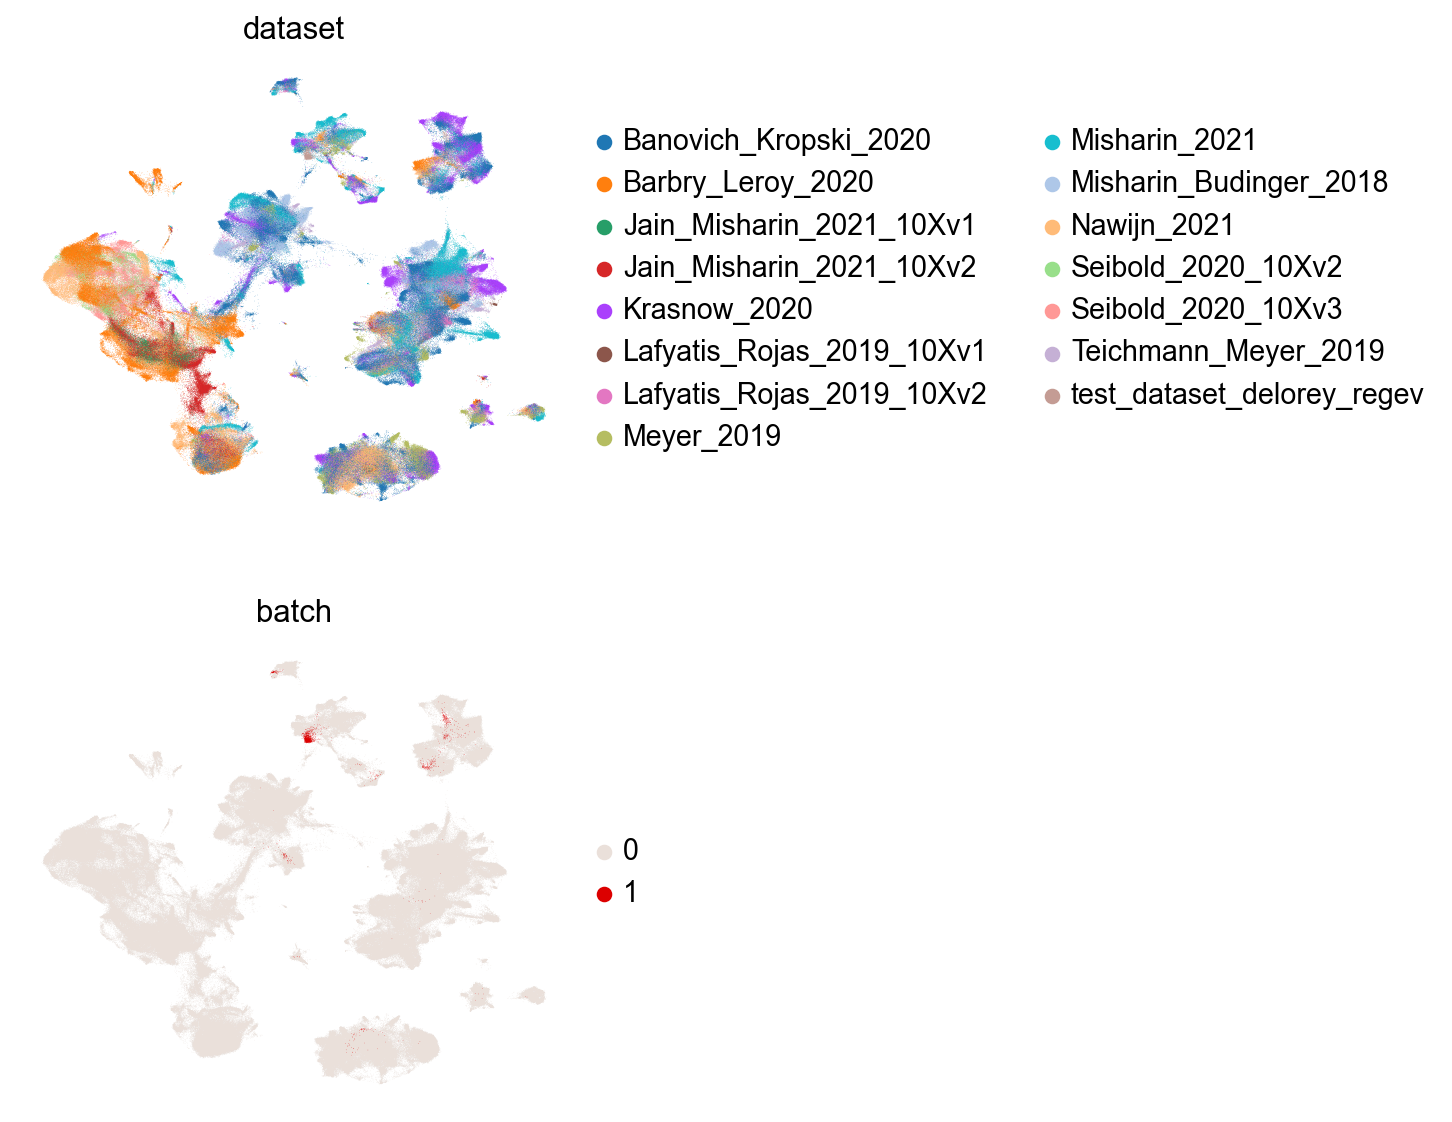

In [29]:
sc.pl.umap(
    combined_emb_umap,
    color=["dataset", "batch"],
    ncols=1,
    frameon=False,
)

Let's plot only batch. It is 1:1 equivalent with the dataset anyway as can be seen below.

In [140]:
idx1 = combined_emb_umap.obs["batch"] == "1"
idx2 = combined_emb_umap.obs["dataset"] == "test_dataset_delorey_regev"
assert idx1.equals(idx2)

In [25]:
sc.set_figure_params(vector_friendly=True, dpi_save=300)

In [26]:
df = combined_emb_umap.obs
default_size = 120000 / len(df) # default scanpy
df["umap_size"] = default_size * 10
df.loc[df["batch"] == "1", "umap_size"] = default_size * 10 # if you want to make the query dataset points bigger
combined_emb_umap.obs = df

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


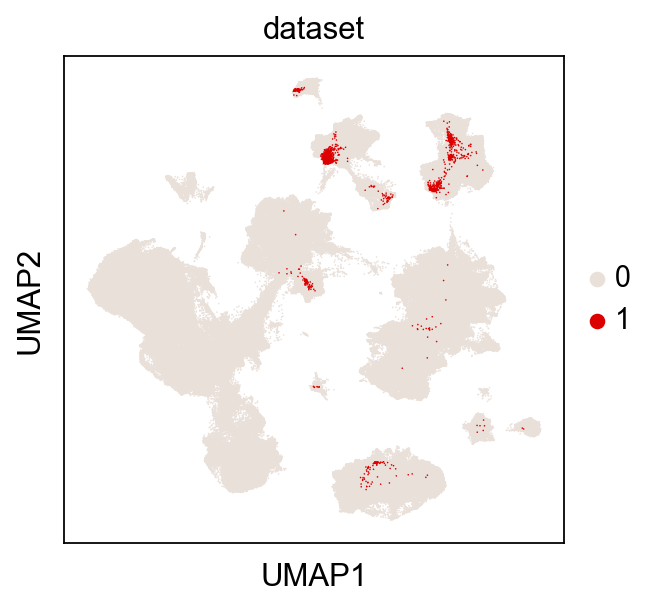

In [30]:
# custom_pal = {"0": "#EAE0DA", "1": "#A0C3D2"}
custom_pal = {"0": "#EAE0DA", "1": "#DC0000"}
sc.pl.umap(
    combined_emb_umap,
    color=["batch"],
    ncols=1,
    frameon=True,
    save="combined_umap_batch.svg",
    palette=custom_pal,
    size=combined_emb_umap.obs["umap_size"],
    title="dataset"
)

In [185]:
# custom_pal = {}
# for i in combined_emb_umap.obs.dataset.cat.categories:
#     custom_pal[i] = "#A7727D" if i == "test_dataset_delorey_regev" else "#EAE0DA"

# sc.pl.umap(
#     combined_emb_umap,
#     color=["dataset"],
#     ncols=1,
#     frameon=False,
#     groups=["test_dataset_delorey_regev"],
#     save="combined_umap_dataset.svg",
#     palette=custom_pal,
#     size=combined_emb_umap.obs["umap_size"],
# )

## 6️⃣ Predict v2

Let's predict using a different cell type than we did earlier, as that is too coarse grained (compartment-level resolution).

In [51]:
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

In [52]:
def distances_to_affinities(distances):
    # convert distances to affinities
    stds = np.std(distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)
    distances_tilda = np.exp(-np.true_divide(distances, stds))
    weights = distances_tilda / np.sum(
        distances_tilda, axis=1, keepdims=True
    )
    return weights

# import numba
# @numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

weights = distances_to_affinities(ref_distances)

### 6️⃣.1️⃣ Figuring out what attribute to predict

Let's see what we can predict that we could then compare to the ground truth in the query data.

In [53]:
metadata.columns

Index(['donor', 'n_genes', 'n_counts', 'percent_mito', 'method', 'doublet',
       'predicted_celltype', 'compartment', 'manual_annotation_cluster',
       'manual_annotation_SubCluster', 'Viral+'],
      dtype='object')

In [54]:
metadata["predicted_celltype"].value_counts()

myofibroblast            1031
vascular endothelial      415
lymphatic endothelial      97
AT1                        62
CD8+ T cell                57
pericyte                   28
club                       12
smc                        12
macrophage                 10
nkt                         8
fibroblast                  8
CD4+ T cell                 7
neutrophil                  7
plasma cell                 7
mast                        6
NK cell                     4
Treg                        3
B cell                      2
cDC                         2
AT2                         2
Name: predicted_celltype, dtype: int64

In [55]:
# "Final annotations by the HLCA expert team, broken down into levels (1 coarsest, 5 finest). Where annotations do not go up to level 5, levels without annotations are set to None."
# source: https://github.com/LungCellAtlas/HLCA/blob/main/docs/HLCA_metadata_explanation.csv
model.adata.obs[[
    "ann_level_1",
    "ann_level_2",
    "ann_level_3",
    "ann_level_4",
    "ann_level_5",
]]

,ann_level_1,ann_level_2,ann_level_3,ann_level_4,ann_level_5
GCGACCATCCCTAACC_SC22,Immune,Myeloid,Macrophages,Alveolar macrophages,None
P2_1_GCGCAACCAGTTAACC,Immune,Lymphoid,Innate lymphoid cell NK,NK cells,None
GCTCTGTAGTGCTGCC_SC27,Epithelial,Alveolar epithelium,AT2,None,None
P2_8_TTAGGACGTTCAGGCC,Immune,Myeloid,Macrophages,Alveolar macrophages,Alveolar Mφ CCL3+
CTTGATTGTCAGTTTG_T164,Epithelial,Airway epithelium,Basal,Suprabasal,None
...,...,...,...,...,...
ACCTTTACATTAACCG_T120,Epithelial,Airway epithelium,Basal,Suprabasal,None
CATTATCTCCATGAAC_F01639,Immune,Myeloid,Dendritic cells,DC2,None
AGGCCGTGTGTGACCC-SC56,Epithelial,Alveolar epithelium,AT2,None,None
CGATGGCAGCAGGCTA-1-2,Epithelial,Airway epithelium,Secretory,Club,Club (nasal)


In [56]:
# too coarse, compartment-level
model.adata.obs["ann_level_1"].value_counts()

Epithelial     282065
Immune         229436
Endothelial     48166
Stroma          25217
Name: ann_level_1, dtype: int64

In [57]:
# still too coarse compared to query dataset 
model.adata.obs["ann_level_2"].value_counts()

Airway epithelium      207253
Myeloid                155315
Lymphoid                74121
Alveolar epithelium     70112
Blood vessels           43571
Fibroblast lineage      21100
Submucosal Gland         4700
Lymphatic EC             4595
Smooth muscle            3887
Mesothelium               230
Name: ann_level_2, dtype: int64

In [58]:
model.adata.obs["ann_level_3"].value_counts()

Macrophages                     111844
Basal                            84713
Secretory                        80557
AT2                              62175
T cell lineage                   50859
Multiciliated lineage            41098
Monocytes                        26529
EC capillary                     23205
Fibroblasts                      20384
Innate lymphoid cell NK          16978
EC venous                        12975
Dendritic cells                  10319
AT1                               7937
EC arterial                       7391
Mast cells                        6623
B cell lineage                    6284
Submucosal Secretory              4700
Lymphatic EC mature               4001
None                              3226
Rare                               885
Myofibroblasts                     716
Lymphatic EC differentiating       566
SM activated stress response       556
Fibromyocytes                      335
Lymphatic EC proliferating          28
Name: ann_level_3, dtype:

In [59]:
model.adata.obs["ann_level_4"].value_counts()

None                         92578
Alveolar macrophages         78816
Suprabasal                   45758
Multiciliated                40094
Basal resting                38955
Goblet                       38471
Club                         38111
Interstitial macrophages     33028
CD8 T cells                  29074
CD4 T cells                  21285
Classical monocytes          17695
NK cells                     16978
EC general capillary         16048
Adventitial fibroblasts      10321
DC2                           9133
Non-classical monocytes       8834
EC aerocyte capillary         7157
EC venous systemic            6557
EC venous pulmonary           6418
Alveolar fibroblasts          5182
B cells                       4511
Transitional Club-AT2         3975
Pericytes                     3032
SMG serous                    2889
Plasma cells                  1773
Peribronchial fibroblasts     1573
SMG duct                      1274
Deuterosomal                  1004
AT2 proliferating   

In [60]:
# too fine
model.adata.obs["ann_level_5"].value_counts()

None                            421962
Goblet (nasal)                   35833
Multiciliated (non-nasal)        35225
Monocyte-derived Mφ              28223
Club (nasal)                     26068
Club (non-nasal)                 12043
Alveolar Mφ CCL3+                 8065
Multiciliated (nasal)             4869
Interstitial Mφ perivascular      4805
Goblet (bronchial)                1670
SMG serous (nasal)                1472
SMG serous (bronchial)            1417
Alveolar Mφ MT-positive           1203
Alveolar Mφ proliferating         1061
Goblet (subsegmental)              968
Name: ann_level_5, dtype: int64

Looks like ann_level_3 or ann_level_4 are the best candidates. Though ann_level_4 has too many None's. Let's use ann_level_3.

### 6️⃣.2️⃣ Predict cell types

In [61]:
label_key = "ann_level_3"
ref_cats = model.adata.obs[label_key].cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(model.adata.obs[label_key].cat.categories)[p]
query_emb.obs["celltype_pred"], query_emb.obs["celltype_uncertainty"] = p, u

### 6️⃣.3️⃣ Evaluate predictions

Finally, let's evaluate predictions.

In [62]:
query_emb.obs[["celltype_pred", "celltype_uncertainty"]]

,celltype_pred,celltype_uncertainty
AAGCGTTTCAGTGCGC,Lymphatic EC mature,3.999908e-01
AGCCACGAGGAGTCTG,Lymphatic EC differentiating,4.999719e-01
ATCATTCGTATTTCGG,Lymphatic EC differentiating,2.000785e-01
TGGCGTGCATGTAACC,Lymphatic EC mature,9.999824e-02
CTACAGACACTGTGAT,EC venous,0.000000e+00
...,...,...
TGATGCACATGGGCAA,AT1,5.960464e-08
AATGACCAGCCGATTT,T cell lineage,0.000000e+00
CTCCATGCACTCTAGA,Fibroblasts,5.960464e-08
ATGGGTTAGAGGCGTT,AT1,9.999967e-02


0.03392964045851922 5.960464477539063e-08


<AxesSubplot: ylabel='Density'>

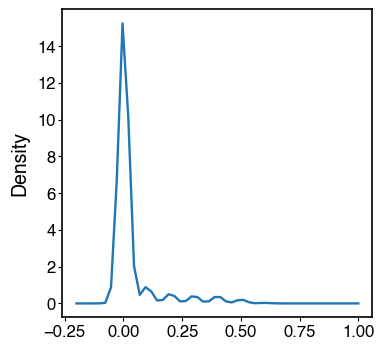

In [63]:
print(query_emb.obs["celltype_uncertainty"].mean(), np.quantile(query_emb.obs["celltype_uncertainty"], 0.75))
query_emb.obs["celltype_uncertainty"].plot(kind='density', ind=np.linspace(-0.2, 1))

Let's plot a sankey plot.

In [65]:
def get_comparison_df(uncertainty_threshold = None):
    # build comparison_df
    assert metadata["predicted_celltype"].index.equals(query_emb.obs.index)
    comparison_df = pd.DataFrame(index=metadata["predicted_celltype"].index, columns=["pred", "ground_truth", "pred_uncertainty"])
    comparison_df["pred"] = query_emb.obs["celltype_pred"]
    comparison_df["pred_uncertainty"] = query_emb.obs["celltype_uncertainty"]
    comparison_df["ground_truth"] = metadata["predicted_celltype"].fillna("Unknown")

    # we dont care about cases where we dont know the ground truth (in fact we could have skipped prediction for these altogether)
    n_before = len(comparison_df)
    comparison_df = comparison_df[comparison_df["ground_truth"] != "Unknown"]
    n_filtered = n_before-len(comparison_df)
    pct_filtered = 100*n_filtered/n_before
    print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with unknown ground truth")

    if uncertainty_threshold is not None:
        # filter out uncertainty > threshold
        n_before = len(comparison_df)
        comparison_df = comparison_df[comparison_df["pred_uncertainty"] <= uncertainty_threshold]
        n_filtered = n_before-len(comparison_df)
        pct_filtered = 100*n_filtered/n_before
        print(f"filtered out {n_filtered} barcodes ({pct_filtered:.2f}%) with pred uncertainty > {uncertainty_threshold}")

    return comparison_df

In [107]:
def plot_sankey(comparison_df):
    # copied, inspired, and adapted from https://stackoverflow.com/a/55468928
    # define nodes
    nodes = [['ID', 'Label', 'Color']]
    name_to_int_pred = {}
    name_to_int_gt = {}
    name_to_color_pred = {}
    orig_palette = ["f94144","f3722c","f8961e","f9c74f","90be6d","43aa8b","577590"] + ["4e598c","005f73","0a9396","94d2bd","e9d8a6","ee9b00","ca6702","bb3e03","ae2012","9b2226"] + ["33658a","86bbd8","758e4f","f6ae2d","f26419"]
    palette = [f"#{i}" for i in orig_palette]
    i = 0
    for _, c in enumerate(comparison_df["pred"].astype("category").cat.categories):
        color = palette[i] # don't cycle in the palette to avoid reusing colors
        nodes.append([i, c, color])
        name_to_int_pred[c] = i
        name_to_color_pred[c] = color
        i += 1

    for _, c in enumerate(comparison_df["ground_truth"].astype("category").cat.categories):
        nodes.append([i, c, "#212529"])
        name_to_int_gt[c] = i
        i += 1

    # define links
    links = [['Source','Target','Value','Link Color']]
    for e in comparison_df[["pred", "ground_truth"]].value_counts().items():
        # e.g. (('EC venous pulmonary', 'vascular endothelial'), 117)
        source = name_to_int_pred[e[0][0]]
        target = name_to_int_gt[e[0][1]]
        value = e[1]
        # color = "rgba(211, 211, 211, 0.5)"
        hex_c = name_to_color_pred[e[0][0]]
        rgb_c = ImageColor.getcolor(hex_c, "RGB")
        color = f"rgba{rgb_c[0], rgb_c[1], rgb_c[2], 0.5}"
        links.append([source, target, value, color])

    # Retrieve headers and build dataframes
    nodes_headers = nodes.pop(0)
    links_headers = links.pop(0)
    df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
    df_links = pd.DataFrame(links, columns = links_headers)

    # Sankey plot setup
    data_trace = dict(
        type='sankey',
        domain = dict(
        x =  [0,1],
        y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
        pad = 10,
        # thickness = 30,
        line = dict(
            color = "black",
            width = 0
        ),
        label =  df_nodes['Label'],
        color = df_nodes['Color']
        ),
        link = dict(
        arrowlen=5,
        source = df_links['Source'],
        target = df_links['Target'],
        value = df_links['Value'],
        color = df_links['Link Color'],
    )
    )

    layout = dict(
        title = "Sankey",
        height = 772,
        width = 500,
        font = dict(size = 10),
        legend_xanchor = "right",
    )

    # from plotly.offline import init_notebook_mode, iplot
    # init_notebook_mode(connected=True)
    # fig = dict(data=[data_trace], layout=layout)
    # iplot(fig, validate=False)

    import plotly.graph_objects as go
    fig = go.Figure(data=[go.Sankey(data_trace)])
    fig.update_layout(layout)
    fig.show()
    fig.write_image(f"{temp_fig_dir}/sankey.pdf")

    # figdf = plt.gcf()
    # figdf.savefig(f"{temp_fig_dir}/sankey.svg", dpi=300, bbox_inches="tight")

In [66]:
comparison_df = get_comparison_df(uncertainty_threshold=0.2)

filtered out 6 barcodes (0.34%) with unknown ground truth
filtered out 126 barcodes (7.08%) with pred uncertainty > 0.2


In [109]:
plot_sankey(comparison_df)

Let's plot heatmap

In [129]:
# https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cellassign_tutorial.html#Model-reproducibility
confusion_matrix = pd.crosstab(
    comparison_df["pred"],
    comparison_df["ground_truth"], 
    rownames=["Predicted label"],
    colnames=["True label"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
confusion_matrix *= 100

<AxesSubplot: xlabel='True label', ylabel='Predicted label'>

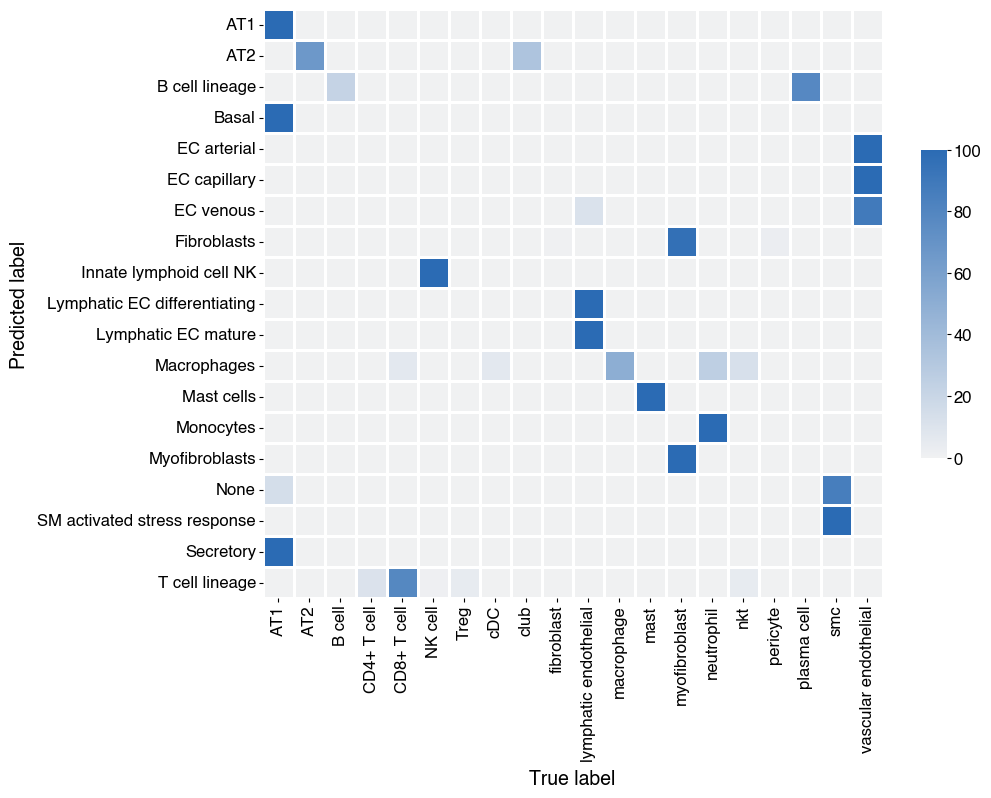

In [130]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    confusion_matrix,
    # cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    ax=ax,
    square=True,
    fmt=".2f",
    cbar_kws=dict(shrink=0.4, aspect=12),
    linecolor='white',
    linewidths=1, 
    # annot=True,
)

In [131]:
# reorder rows and cols to make it look more diagonal

new_rows = [
    "AT1",
    "Basal",
    "Secretory",
    "AT2",
    "B cell lineage",
    "EC arterial",
    "EC capillary",
    "EC venous",
    "Lymphatic EC differentiating",
    "Lymphatic EC mature",
    "Fibroblasts",
    "Myofibroblasts",
    "Innate lymphoid cell NK",
    "Macrophages",
    "Monocytes",
    "Mast cells",
    "T cell lineage",
    "SM activated stress response",
    "None",
]

new_cols = [
    "AT1",
    "AT2",
    "club",
    "B cell",
    "plasma cell",
    "vascular endothelial",
    "lymphatic endothelial",
    "fibroblast",
    "myofibroblast",
    "NK cell",
    "macrophage",
    "neutrophil",
    "mast",
    "CD8+ T cell",
    "CD4+ T cell",
    "smc",
    "Treg",
    "nkt",
    "cDC",
    "pericyte",
]

confusion_matrix_reordered = confusion_matrix.loc[new_rows, new_cols]

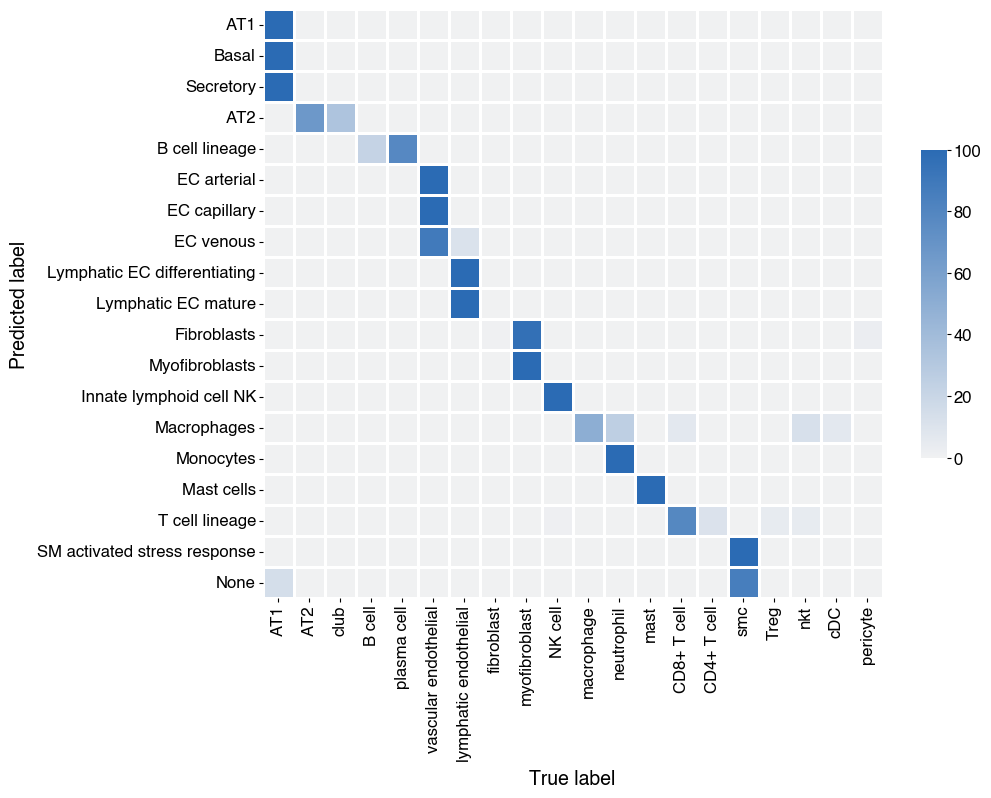

In [132]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    confusion_matrix_reordered,
    cmap=sns.color_palette("light:#2b6bb4", as_cmap=True),
    ax=ax,
    square=True,
    fmt=".2f",
    cbar_kws=dict(shrink=0.4, aspect=12),
    linecolor='white',
    linewidths=1, 
)

temp_fig_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs"
fig_path = f'{temp_fig_dir}/celltype_preds.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

In [129]:
len(comparison_df["ground_truth"].astype("category").cat.categories), len(comparison_df["pred"].astype("category").cat.categories)

(20, 18)

## 7️⃣ Gene signature UMAP's

In [129]:
adata2 = model.adata.copy()

In [130]:
model.adata.X = csr_matrix(model.posterior_predictive_sample(
    model.adata,
    n_samples=1,
    batch_size=32,
))

In [109]:
# # add granzyme a and b expressions and subtract ccr7 and sell expressions -- this will act as a proxy to detect CD8 memory vs naive in terms of expression
# var_idx_1 = model.adata.var.feature_name.isin(["GZMB", "GZMA"])
# var_idx_2 = model.adata.var.feature_name.isin(["CCR7", "SELL"])
# sig = model.adata[:, var_idx_1].X.sum(1) - model.adata[:, var_idx_2].X.sum(1)
# model.adata.obs["CD8_memory_vs_naive"] = sig.toarray()

In [155]:
# B cells: CD79A, MZB1, MS4A1, JCHAIN
# T cells: CD3D, CD3E, CD2, CD5, LEF1, NKG7

var_idx_t = model.adata.var.feature_name.isin(["CD3D"])
model.adata.obs["t_cells"] = np.log1p(model.adata[:, var_idx_t].X.sum(1))

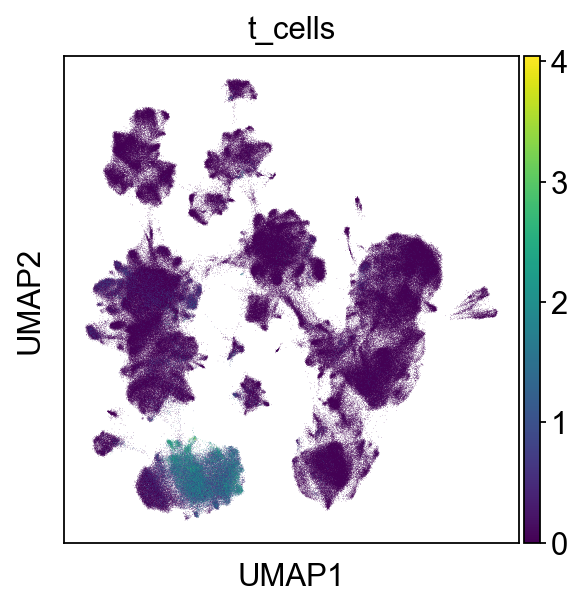

PosixPath('/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs/umap_markers.svg')

In [156]:
sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=14)
sc.pl.umap(
    model.adata,
    color=["t_cells"],
    save="_markers.svg",
)

# move the fig to another directory
temp_fig_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs"
scanpy_fig_path = Path("figures/umap_markers.svg").resolve()
scanpy_fig_path.replace(os.path.join(temp_fig_dir, "umap_markers.svg"))